<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v4.0.0_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [7]:
## section: Data manioulation
import math
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [8]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda Using number of workers:  4

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Step01: Data exploration

In [9]:
## Download from FashionMNIST
dataset = 'FashionMNIST' # change this one
torch.manual_seed(1311)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 3
Preview Images with Label : T-shirt/top
Show of images unique 10 labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


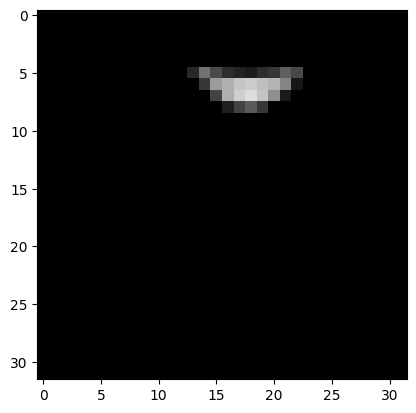

In [10]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [11]:
batch_size = 16

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

Training set: 48000 items, 3000 batches
Validation set: 12000 items, 750 batches
Test set: 10000 items, 625 batches


### check test set classes distribution

In [12]:
from collections import Counter

# Assuming testing_data is your test dataset
test_labels = [label for _, label in testing_data]

# Count the occurrences of each class
class_distribution = Counter(test_labels)

# Print the distribution
total_samples = sum(class_distribution.values())
for class_id, count in class_distribution.items():
    percentage = (count / total_samples) * 100
    print(f'Class {classes[class_id]}: {count} samples, {percentage:.2f}% of the test set')

Class Ankle boot: 1000 samples, 10.00% of the test set
Class Pullover: 1000 samples, 10.00% of the test set
Class Trouser: 1000 samples, 10.00% of the test set
Class Shirt: 1000 samples, 10.00% of the test set
Class Coat: 1000 samples, 10.00% of the test set
Class Sandal: 1000 samples, 10.00% of the test set
Class Sneaker: 1000 samples, 10.00% of the test set
Class Dress: 1000 samples, 10.00% of the test set
Class Bag: 1000 samples, 10.00% of the test set
Class T-shirt/top: 1000 samples, 10.00% of the test set


### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


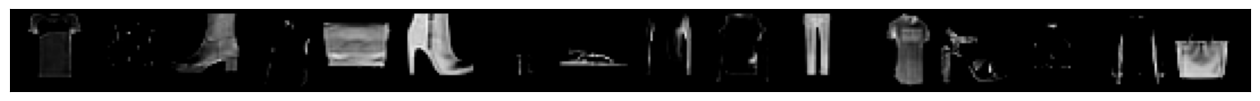

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [14]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

# def evaluate(model, dataloader, criterion, device, num_class, class_eva = False):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     class_correct = list(0. for i in range(num_class))
#     class_total = list(0. for i in range(num_class))

#     with torch.no_grad():
#         for inputs, labels in tqdm(dataloader, desc='Evaluating'):
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct += torch.sum(preds == labels.data)
#             total += labels.size(0)
#             if class_eva:
#                 c = (preds == labels).squeeze()
#                 for i in range(labels.size(0)):
#                     label = labels[i]
#                     class_correct[label] += c[i].item()
#                     class_total[label] += 1

#     loss = running_loss / total
#     accuracy = correct.double() / total

#     if class_eva:
#         return loss, accuracy, class_correct, class_total
#     else:
#         return loss, accuracy

def evaluate(model, dataloader, criterion, device, num_class, class_eva=False, store_examples=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    best_correct = None
    worst_incorrect = None

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            if store_examples:
                probabilities = F.softmax(outputs, dim=1)
                for i in range(inputs.size(0)):
                    confidence, predicted_label = torch.max(probabilities[i], 0)
                    actual_label = labels[i].item()
                    if predicted_label.item() == actual_label:
                        if best_correct is None or confidence > best_correct['confidence']:
                            best_correct = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                            }
                    else:
                        if worst_incorrect is None or confidence < worst_incorrect['confidence']:
                            worst_incorrect = {
                                'confidence': confidence,
                                'image': inputs[i],
                                'label': actual_label,
                                'predicted_label': predicted_label.item(),
                            }

            if class_eva:
                c = (preds == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

    loss = running_loss / total
    accuracy = correct.double() / total

    results = (loss, accuracy)
    if class_eva:
        results += (class_correct, class_total)
    if store_examples:
        results += (best_correct, worst_incorrect)

    return results

def display_image(image):
    if isinstance(image, dict):
        image = image['image']
    image = image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.show()

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'best_correct': [],
        'worst_incorrect': [],
    }
    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device, num_class)


        # Step the scheduler with the validation loss
        scheduler.step()
        # scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))

    test_loss, test_acc, class_correct, class_total = evaluate(best_model, testloader, criterion, device, num_class, class_eva=True)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')
    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    ## section04: Load the best model for final evaluation on test set for each class
    print(f'Test Acc on each class')
    class_results = {}
    for i in range(num_class):
        if class_total[i] > 0:
            results = 100 * class_correct[i] / class_total[i]
            class_results[classes[i]] = results
            print('Accuracy of class %s : %2d %%' % (classes[i], results))
        else:
            class_results[classes[i]] = 0
            print('Accuracy of class %s : N/A (no samples in test set)' % classes[i])

    history['class_results'] = class_results

    ## section04: collect the best and worst image
    test_loss, test_acc, best_correct, worst_incorrect = evaluate(
        best_model,
        testloader,
        criterion,
        device,
        num_class,
        class_eva=False,
        store_examples=True
    )
    history['best_correct'].append(best_correct)
    history['worst_incorrect'].append(worst_incorrect)
    print('Best Correct Prediction:')
    print('Confidence:', best_correct['confidence'].item())
    # print('Label:', int(best_correct['label']))
    print('Index:',  int(best_correct['label']), "- Labels: ",classes[int(best_correct['label'])])
    display_image(best_correct['image'])

    print('\nWorst Incorrect Prediction:')
    print('Confidence:', worst_incorrect['confidence'].item())
    print('Actual Index:', int(worst_incorrect['label']), "- Labels: ",classes[int(worst_incorrect['label'])])
    print('Predicted Index:', int(worst_incorrect['predicted_label']), "- Labels: ",classes[int(worst_incorrect['predicted_label'])])
    display_image(worst_incorrect['image'])

    return history

## Initialize network

### network: VGG19

In [15]:
__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

### network: Alexnet

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [18]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [19]:
# set the whole network training
num_epochs = 20
criterion = nn.CrossEntropyLoss()

### Check number of parameter

In [20]:
from torchsummary import summary
for i in [AlexNet(), vgg19(), ResNet18(), ResNet34(), ResNet50()]:
    print("Model: ", i.__class__.__name__)
    print("Number of parameters: ", sum(p.numel() for p in i.parameters() if p.requires_grad))
    summary(i.to(device), (3, 32, 32))
    print("-"*50)

Model:  AlexNet
Number of parameters:  56826698
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 192, 16, 16]         110,784
              ReLU-5          [-1, 192, 16, 16]               0
         MaxPool2d-6            [-1, 192, 8, 8]               0
            Conv2d-7            [-1, 384, 8, 8]         663,936
              ReLU-8            [-1, 384, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         884,992
             ReLU-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         590,080
             ReLU-12            [-1, 256, 8, 8]               0
        MaxPool2d-13            [-1, 256, 4, 4]        

### Train the network - Alexnet

Model will be saved to: ./FashionMNIST_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:07<00:00, 95.66it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 1/20, Train Loss: 2.0532, Train Acc: 22.43%, Val Loss: 0.9970, Val Acc: 62.20%, Time: 70.64s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.53it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 2/20, Train Loss: 0.8330, Train Acc: 68.54%, Val Loss: 0.6794, Val Acc: 72.97%, Time: 72.74s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.33it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 3/20, Train Loss: 0.6645, Train Acc: 74.65%, Val Loss: 0.6060, Val Acc: 76.20%, Time: 77.28s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 88.85it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 4/20, Train Loss: 0.6002, Train Acc: 76.92%, Val Loss: 0.5628, Val Acc: 78.17%, Time: 70.68s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.89it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 5/20, Train Loss: 0.5572, Train Acc: 78.68%, Val Loss: 0.5086, Val Acc: 80.70%, Time: 72.83s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.26it/s] 


Epoch 6/20, Train Loss: 0.5149, Train Acc: 80.57%, Val Loss: 0.5056, Val Acc: 80.37%, Time: 71.81s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.89it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 7/20, Train Loss: 0.4810, Train Acc: 81.84%, Val Loss: 0.4410, Val Acc: 83.51%, Time: 72.78s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 92.14it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 8/20, Train Loss: 0.4496, Train Acc: 83.08%, Val Loss: 0.4177, Val Acc: 84.03%, Time: 71.04s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.77it/s] 


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 9/20, Train Loss: 0.4284, Train Acc: 83.99%, Val Loss: 0.3886, Val Acc: 85.52%, Time: 71.90s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 88.11it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 10/20, Train Loss: 0.4093, Train Acc: 84.66%, Val Loss: 0.3810, Val Acc: 85.61%, Time: 71.52s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.52it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 11/20, Train Loss: 0.3885, Train Acc: 85.40%, Val Loss: 0.3480, Val Acc: 86.80%, Time: 71.54s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 89.20it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 12/20, Train Loss: 0.3731, Train Acc: 86.12%, Val Loss: 0.3360, Val Acc: 87.52%, Time: 71.46s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.61it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 13/20, Train Loss: 0.3594, Train Acc: 86.60%, Val Loss: 0.3264, Val Acc: 87.98%, Time: 71.30s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 90.45it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 14/20, Train Loss: 0.3506, Train Acc: 86.98%, Val Loss: 0.3104, Val Acc: 88.52%, Time: 71.23s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.52it/s] 


Epoch 15/20, Train Loss: 0.3447, Train Acc: 87.11%, Val Loss: 0.3264, Val Acc: 87.51%, Time: 70.68s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 93.30it/s]


Epoch 16/20, Train Loss: 0.3341, Train Acc: 87.53%, Val Loss: 0.3196, Val Acc: 87.98%, Time: 69.96s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.84it/s] 


Epoch 17/20, Train Loss: 0.3253, Train Acc: 87.69%, Val Loss: 0.3171, Val Acc: 88.16%, Time: 71.39s


Evaluating: 100%|██████████| 750/750 [00:07<00:00, 94.10it/s]


Model improved and saved to ./FashionMNIST_alexnet.pth
Epoch 18/20, Train Loss: 0.3189, Train Acc: 88.19%, Val Loss: 0.3013, Val Acc: 88.84%, Time: 71.01s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.18it/s]


Epoch 19/20, Train Loss: 0.3152, Train Acc: 88.18%, Val Loss: 0.3024, Val Acc: 88.67%, Time: 71.86s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 91.83it/s] 


Epoch 20/20, Train Loss: 0.3071, Train Acc: 88.61%, Val Loss: 0.3007, Val Acc: 88.83%, Time: 69.75s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 85.44it/s] 


Test Loss: 0.2927, Test Acc: 89.41%
Test Acc on each class
Accuracy of class T-shirt/top : 88 %
Accuracy of class Trouser : 98 %
Accuracy of class Pullover : 83 %
Accuracy of class Dress : 89 %
Accuracy of class Coat : 88 %
Accuracy of class Sandal : 97 %
Accuracy of class Shirt : 61 %
Accuracy of class Sneaker : 93 %
Accuracy of class Bag : 97 %
Accuracy of class Ankle boot : 95 %


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 97.50it/s]


Best Correct Prediction:
Confidence: 0.9999994039535522
Index: 1 - Labels:  Trouser


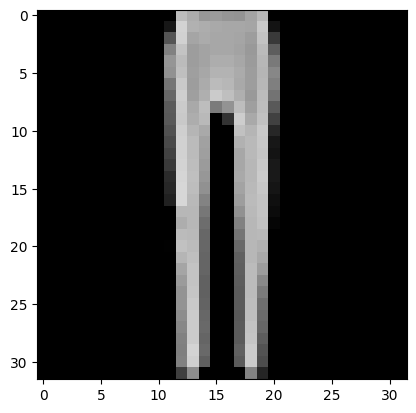


Worst Incorrect Prediction:
Confidence: 0.25353386998176575
Actual Index: 6 - Labels:  Shirt
Predicted Index: 1 - Labels:  Trouser


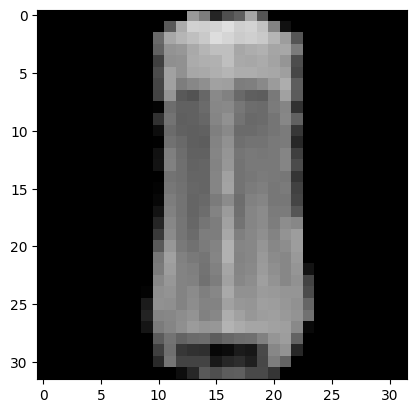

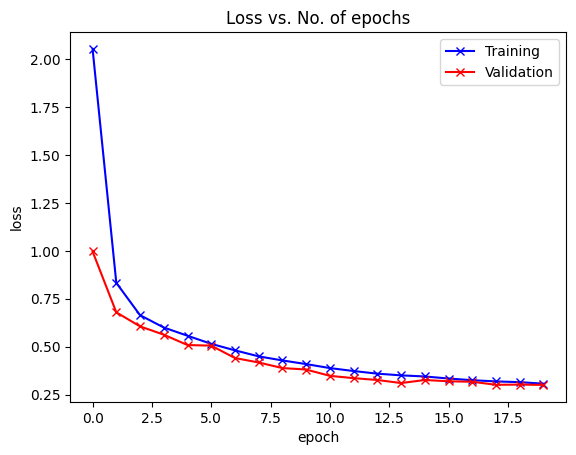

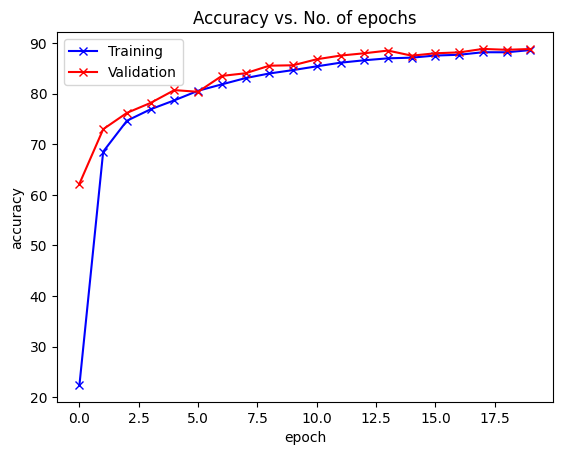

Test Loss: 0.2927, Test Accuracy: 89.41%


In [21]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy

print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

### Train the network - VGG19

Model will be saved to: ./FashionMNIST_vggnet19.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.03it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 1/20, Train Loss: 2.2279, Train Acc: 13.76%, Val Loss: 1.4688, Val Acc: 36.50%, Time: 76.17s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 76.36it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 2/20, Train Loss: 0.9700, Train Acc: 61.95%, Val Loss: 0.7031, Val Acc: 72.94%, Time: 76.25s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 74.93it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 3/20, Train Loss: 0.6660, Train Acc: 74.53%, Val Loss: 0.5793, Val Acc: 77.06%, Time: 76.47s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 74.71it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 4/20, Train Loss: 0.5818, Train Acc: 77.71%, Val Loss: 0.5083, Val Acc: 80.04%, Time: 78.12s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.14it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 5/20, Train Loss: 0.5207, Train Acc: 80.43%, Val Loss: 0.4846, Val Acc: 81.55%, Time: 76.05s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 76.08it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 6/20, Train Loss: 0.4783, Train Acc: 82.41%, Val Loss: 0.4341, Val Acc: 83.56%, Time: 76.05s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.97it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 7/20, Train Loss: 0.4409, Train Acc: 83.50%, Val Loss: 0.4089, Val Acc: 84.77%, Time: 75.42s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.74it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 8/20, Train Loss: 0.4133, Train Acc: 85.09%, Val Loss: 0.4000, Val Acc: 84.79%, Time: 75.25s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 87.66it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 9/20, Train Loss: 0.3899, Train Acc: 85.83%, Val Loss: 0.3796, Val Acc: 86.33%, Time: 74.80s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.08it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 10/20, Train Loss: 0.3712, Train Acc: 86.51%, Val Loss: 0.3386, Val Acc: 87.89%, Time: 75.23s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.62it/s]


Epoch 11/20, Train Loss: 0.3531, Train Acc: 87.25%, Val Loss: 0.3313, Val Acc: 87.83%, Time: 74.97s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.52it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 12/20, Train Loss: 0.3376, Train Acc: 87.80%, Val Loss: 0.3342, Val Acc: 88.02%, Time: 75.29s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.04it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 13/20, Train Loss: 0.3248, Train Acc: 88.20%, Val Loss: 0.3103, Val Acc: 88.60%, Time: 75.10s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 74.95it/s]


Model improved and saved to ./FashionMNIST_vggnet19.pth
Epoch 14/20, Train Loss: 0.3183, Train Acc: 88.39%, Val Loss: 0.2878, Val Acc: 89.69%, Time: 76.63s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.23it/s]


Epoch 15/20, Train Loss: 0.3076, Train Acc: 88.80%, Val Loss: 0.3143, Val Acc: 88.51%, Time: 76.06s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 84.14it/s]


Epoch 16/20, Train Loss: 0.2993, Train Acc: 89.17%, Val Loss: 0.2865, Val Acc: 89.63%, Time: 75.87s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 83.13it/s]


Epoch 17/20, Train Loss: 0.2914, Train Acc: 89.41%, Val Loss: 0.2997, Val Acc: 88.89%, Time: 76.03s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.41it/s]


Epoch 18/20, Train Loss: 0.2839, Train Acc: 89.85%, Val Loss: 0.2833, Val Acc: 89.64%, Time: 76.49s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.61it/s]


Epoch 19/20, Train Loss: 0.2809, Train Acc: 89.88%, Val Loss: 0.2837, Val Acc: 89.39%, Time: 76.22s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 76.86it/s]


Epoch 20/20, Train Loss: 0.2738, Train Acc: 90.23%, Val Loss: 0.2787, Val Acc: 89.68%, Time: 75.66s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:07<00:00, 83.01it/s]


Test Loss: 0.2858, Test Acc: 89.61%
Test Acc on each class
Accuracy of class T-shirt/top : 82 %
Accuracy of class Trouser : 98 %
Accuracy of class Pullover : 79 %
Accuracy of class Dress : 89 %
Accuracy of class Coat : 86 %
Accuracy of class Sandal : 97 %
Accuracy of class Shirt : 74 %
Accuracy of class Sneaker : 97 %
Accuracy of class Bag : 97 %
Accuracy of class Ankle boot : 94 %


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 92.96it/s] 


Best Correct Prediction:
Confidence: 0.9999980926513672
Index: 5 - Labels:  Sandal


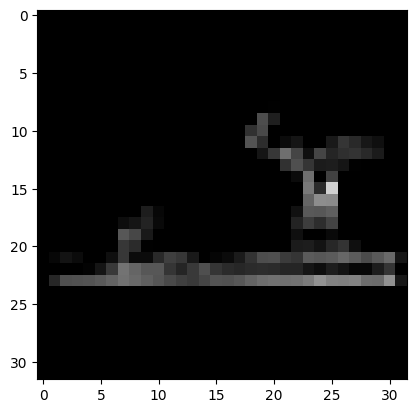


Worst Incorrect Prediction:
Confidence: 0.2992013692855835
Actual Index: 6 - Labels:  Shirt
Predicted Index: 2 - Labels:  Pullover


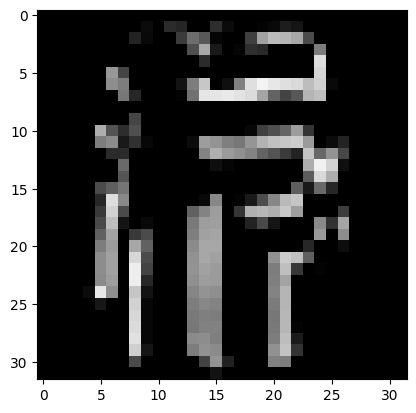

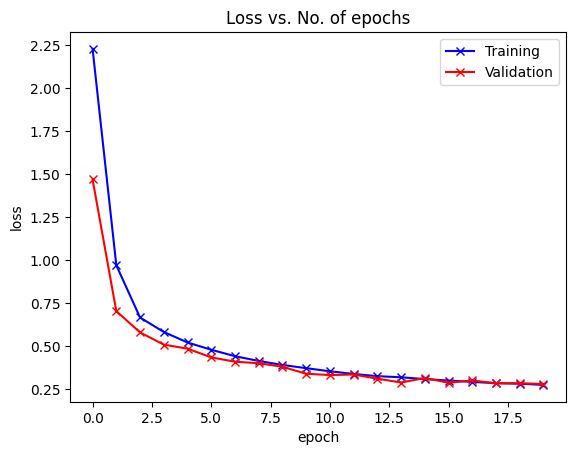

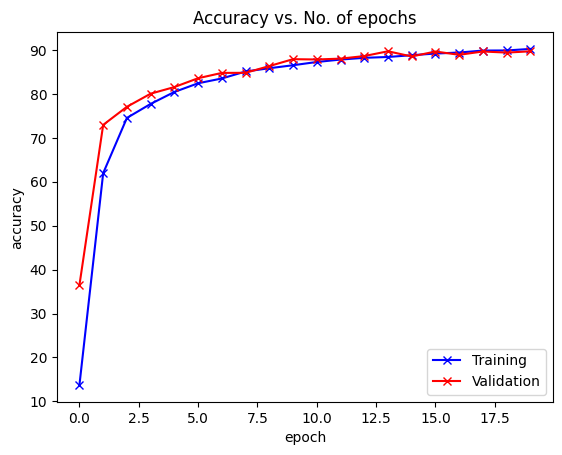

In [22]:
# individual configuration
vggnet19 = vgg19().to(device)
model_name = "vggnet19"
model = vggnet19

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
vggnet19_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(vggnet19_results['train_loss'], vggnet19_results['val_loss'])
plot_acc(vggnet19_results['train_accuracy'], vggnet19_results['val_accuracy'])

### Train the network - Resnet18

Model will be saved to: ./FashionMNIST_resnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.93it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 1/20, Train Loss: 0.6017, Train Acc: 77.68%, Val Loss: 0.3886, Val Acc: 85.38%, Time: 89.01s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.25it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 2/20, Train Loss: 0.3798, Train Acc: 86.08%, Val Loss: 0.3016, Val Acc: 89.18%, Time: 90.44s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 80.15it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 3/20, Train Loss: 0.3216, Train Acc: 88.33%, Val Loss: 0.2957, Val Acc: 89.39%, Time: 90.77s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.60it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 4/20, Train Loss: 0.2899, Train Acc: 89.51%, Val Loss: 0.2595, Val Acc: 90.72%, Time: 89.74s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.00it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 5/20, Train Loss: 0.2676, Train Acc: 90.24%, Val Loss: 0.2395, Val Acc: 91.29%, Time: 89.96s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.74it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 6/20, Train Loss: 0.2519, Train Acc: 90.85%, Val Loss: 0.2408, Val Acc: 91.31%, Time: 88.71s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.52it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 7/20, Train Loss: 0.2376, Train Acc: 91.35%, Val Loss: 0.2196, Val Acc: 92.08%, Time: 89.52s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 75.81it/s]


Epoch 8/20, Train Loss: 0.2252, Train Acc: 91.61%, Val Loss: 0.2383, Val Acc: 91.43%, Time: 89.33s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 74.83it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 9/20, Train Loss: 0.2171, Train Acc: 92.01%, Val Loss: 0.2182, Val Acc: 92.40%, Time: 89.99s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 74.77it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 10/20, Train Loss: 0.2116, Train Acc: 92.35%, Val Loss: 0.2091, Val Acc: 92.41%, Time: 89.97s


Evaluating: 100%|██████████| 750/750 [00:10<00:00, 72.94it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 11/20, Train Loss: 0.2040, Train Acc: 92.51%, Val Loss: 0.2065, Val Acc: 92.77%, Time: 90.50s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 76.19it/s]


Epoch 12/20, Train Loss: 0.1945, Train Acc: 92.85%, Val Loss: 0.2050, Val Acc: 92.73%, Time: 88.95s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 75.26it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 13/20, Train Loss: 0.1892, Train Acc: 93.17%, Val Loss: 0.1935, Val Acc: 93.09%, Time: 89.78s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 78.24it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 14/20, Train Loss: 0.1831, Train Acc: 93.29%, Val Loss: 0.1876, Val Acc: 93.30%, Time: 89.24s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 77.45it/s]


Epoch 15/20, Train Loss: 0.1777, Train Acc: 93.50%, Val Loss: 0.1999, Val Acc: 92.94%, Time: 89.12s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.89it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 16/20, Train Loss: 0.1700, Train Acc: 93.82%, Val Loss: 0.1836, Val Acc: 93.46%, Time: 88.75s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 79.76it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 17/20, Train Loss: 0.1665, Train Acc: 93.94%, Val Loss: 0.1872, Val Acc: 93.55%, Time: 89.25s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 82.14it/s]


Model improved and saved to ./FashionMNIST_resnet18.pth
Epoch 18/20, Train Loss: 0.1627, Train Acc: 94.08%, Val Loss: 0.1818, Val Acc: 93.62%, Time: 88.86s


Evaluating: 100%|██████████| 750/750 [00:09<00:00, 81.70it/s]


Epoch 19/20, Train Loss: 0.1566, Train Acc: 94.34%, Val Loss: 0.1865, Val Acc: 93.42%, Time: 88.95s


Evaluating: 100%|██████████| 750/750 [00:08<00:00, 83.83it/s]


Epoch 20/20, Train Loss: 0.1527, Train Acc: 94.40%, Val Loss: 0.1854, Val Acc: 93.25%, Time: 88.76s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 77.94it/s]


Test Loss: 0.1906, Test Acc: 93.38%
Test Acc on each class
Accuracy of class T-shirt/top : 87 %
Accuracy of class Trouser : 98 %
Accuracy of class Pullover : 90 %
Accuracy of class Dress : 95 %
Accuracy of class Coat : 93 %
Accuracy of class Sandal : 99 %
Accuracy of class Shirt : 77 %
Accuracy of class Sneaker : 95 %
Accuracy of class Bag : 99 %
Accuracy of class Ankle boot : 97 %


Evaluating: 100%|██████████| 625/625 [00:08<00:00, 76.64it/s]


Best Correct Prediction:
Confidence: 0.9999998807907104
Index: 8 - Labels:  Bag


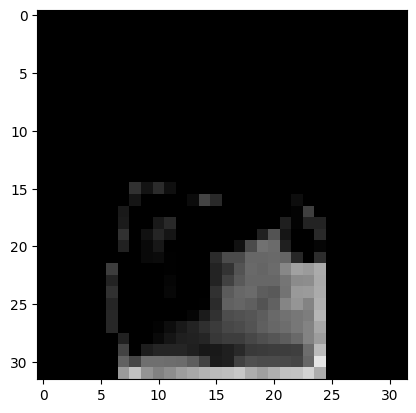


Worst Incorrect Prediction:
Confidence: 0.27322521805763245
Actual Index: 0 - Labels:  T-shirt/top
Predicted Index: 2 - Labels:  Pullover


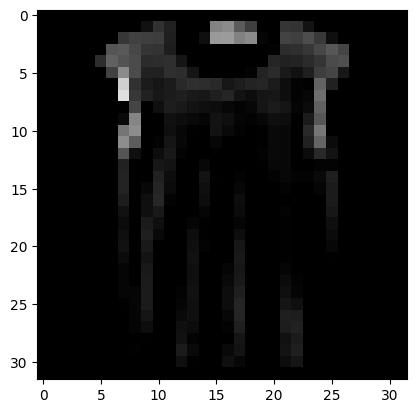

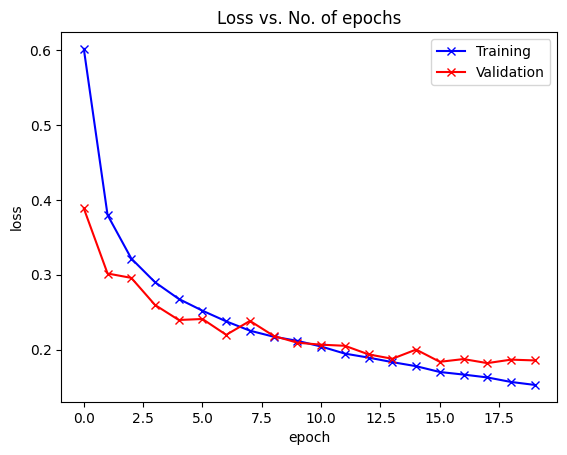

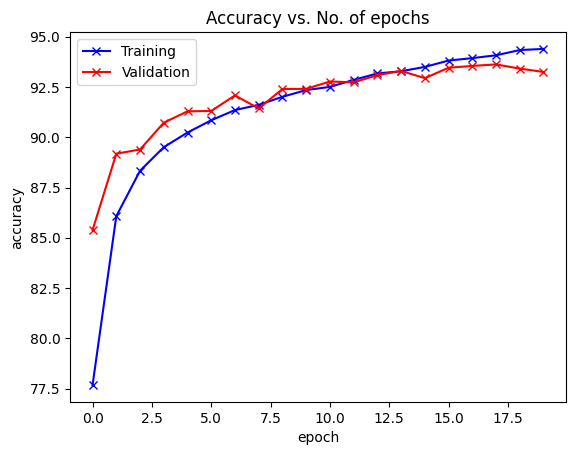

In [23]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])

### Train the network - Resnet34

Model will be saved to: ./FashionMNIST_resnet34.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.19it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 1/20, Train Loss: 0.6108, Train Acc: 77.54%, Val Loss: 0.3894, Val Acc: 85.39%, Time: 140.01s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 62.06it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 2/20, Train Loss: 0.3750, Train Acc: 86.52%, Val Loss: 0.2939, Val Acc: 89.16%, Time: 140.20s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.58it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 3/20, Train Loss: 0.3172, Train Acc: 88.50%, Val Loss: 0.2721, Val Acc: 90.14%, Time: 141.02s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.86it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 4/20, Train Loss: 0.2836, Train Acc: 89.64%, Val Loss: 0.2672, Val Acc: 90.30%, Time: 140.66s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.94it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 5/20, Train Loss: 0.2613, Train Acc: 90.46%, Val Loss: 0.2404, Val Acc: 91.42%, Time: 140.54s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.78it/s]


Epoch 6/20, Train Loss: 0.2452, Train Acc: 90.96%, Val Loss: 0.2450, Val Acc: 91.20%, Time: 140.71s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.39it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 7/20, Train Loss: 0.2306, Train Acc: 91.48%, Val Loss: 0.2282, Val Acc: 91.87%, Time: 140.92s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.05it/s]


Epoch 8/20, Train Loss: 0.2195, Train Acc: 91.94%, Val Loss: 0.2371, Val Acc: 91.43%, Time: 140.86s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.54it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 9/20, Train Loss: 0.2110, Train Acc: 92.29%, Val Loss: 0.2151, Val Acc: 92.25%, Time: 141.14s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 62.17it/s]


Epoch 10/20, Train Loss: 0.2034, Train Acc: 92.49%, Val Loss: 0.2162, Val Acc: 92.09%, Time: 140.02s


Evaluating: 100%|██████████| 750/750 [00:11<00:00, 63.39it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 11/20, Train Loss: 0.1990, Train Acc: 92.64%, Val Loss: 0.1991, Val Acc: 92.81%, Time: 139.99s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 58.59it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 12/20, Train Loss: 0.1875, Train Acc: 93.08%, Val Loss: 0.1922, Val Acc: 93.21%, Time: 141.68s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.16it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 13/20, Train Loss: 0.1797, Train Acc: 93.50%, Val Loss: 0.1964, Val Acc: 93.27%, Time: 140.72s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.79it/s]


Epoch 14/20, Train Loss: 0.1755, Train Acc: 93.59%, Val Loss: 0.1935, Val Acc: 93.03%, Time: 140.08s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.07it/s]


Epoch 15/20, Train Loss: 0.1707, Train Acc: 93.78%, Val Loss: 0.2051, Val Acc: 92.63%, Time: 139.97s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.54it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 16/20, Train Loss: 0.1615, Train Acc: 93.99%, Val Loss: 0.1855, Val Acc: 93.55%, Time: 139.95s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.16it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 17/20, Train Loss: 0.1577, Train Acc: 94.26%, Val Loss: 0.1888, Val Acc: 93.57%, Time: 140.06s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 61.21it/s]


Epoch 18/20, Train Loss: 0.1536, Train Acc: 94.42%, Val Loss: 0.1880, Val Acc: 93.38%, Time: 139.72s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.85it/s]


Epoch 19/20, Train Loss: 0.1477, Train Acc: 94.59%, Val Loss: 0.1839, Val Acc: 93.57%, Time: 140.07s


Evaluating: 100%|██████████| 750/750 [00:12<00:00, 60.56it/s]


Model improved and saved to ./FashionMNIST_resnet34.pth
Epoch 20/20, Train Loss: 0.1431, Train Acc: 94.67%, Val Loss: 0.1843, Val Acc: 93.70%, Time: 140.75s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:09<00:00, 63.85it/s]


Test Loss: 0.1797, Test Acc: 93.68%
Test Acc on each class
Accuracy of class T-shirt/top : 86 %
Accuracy of class Trouser : 99 %
Accuracy of class Pullover : 89 %
Accuracy of class Dress : 92 %
Accuracy of class Coat : 93 %
Accuracy of class Sandal : 98 %
Accuracy of class Shirt : 83 %
Accuracy of class Sneaker : 97 %
Accuracy of class Bag : 99 %
Accuracy of class Ankle boot : 96 %


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 61.50it/s]


Best Correct Prediction:
Confidence: 0.9999996423721313
Index: 8 - Labels:  Bag


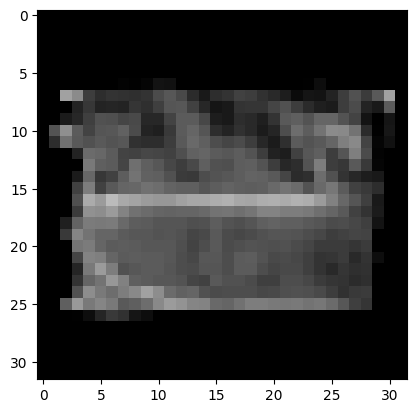


Worst Incorrect Prediction:
Confidence: 0.30425170063972473
Actual Index: 8 - Labels:  Bag
Predicted Index: 6 - Labels:  Shirt


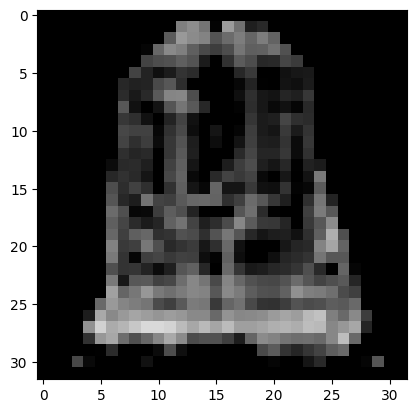

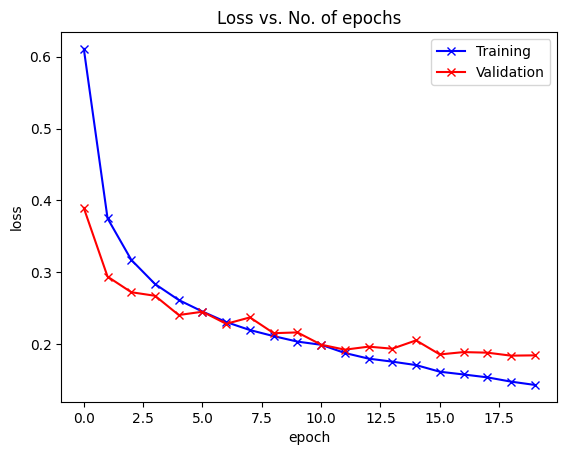

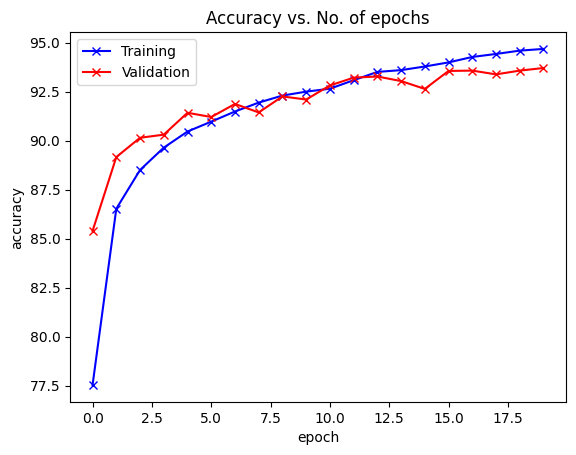

In [24]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet34_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )


# Plot the results
plot_loss(resnet34_results['train_loss'], resnet34_results['val_loss'])
plot_acc(resnet34_results['train_accuracy'], resnet34_results['val_accuracy'])

### Train the network - Resnet50

Model will be saved to: ./FashionMNIST_resnet50.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 750/750 [00:15<00:00, 48.01it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 1/20, Train Loss: 0.7390, Train Acc: 73.59%, Val Loss: 0.9412, Val Acc: 66.45%, Time: 228.95s


Evaluating: 100%|██████████| 750/750 [00:15<00:00, 48.89it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 2/20, Train Loss: 0.4268, Train Acc: 84.84%, Val Loss: 0.3245, Val Acc: 88.52%, Time: 227.84s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.39it/s]


Epoch 3/20, Train Loss: 0.3506, Train Acc: 87.54%, Val Loss: 0.3223, Val Acc: 88.47%, Time: 228.62s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.89it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 4/20, Train Loss: 0.3080, Train Acc: 88.91%, Val Loss: 0.2605, Val Acc: 90.62%, Time: 226.40s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.11it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 5/20, Train Loss: 0.2803, Train Acc: 89.88%, Val Loss: 0.2582, Val Acc: 90.77%, Time: 226.50s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.98it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 6/20, Train Loss: 0.2567, Train Acc: 90.71%, Val Loss: 0.2370, Val Acc: 91.62%, Time: 226.49s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.98it/s]


Epoch 7/20, Train Loss: 0.2444, Train Acc: 91.04%, Val Loss: 0.2369, Val Acc: 91.62%, Time: 224.35s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.50it/s]


Epoch 8/20, Train Loss: 0.2295, Train Acc: 91.66%, Val Loss: 0.2476, Val Acc: 91.09%, Time: 225.67s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.24it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 9/20, Train Loss: 0.2193, Train Acc: 92.10%, Val Loss: 0.2304, Val Acc: 91.80%, Time: 228.86s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.54it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 10/20, Train Loss: 0.2140, Train Acc: 92.09%, Val Loss: 0.2078, Val Acc: 92.70%, Time: 229.20s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.54it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 11/20, Train Loss: 0.2072, Train Acc: 92.42%, Val Loss: 0.2033, Val Acc: 92.90%, Time: 227.85s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.30it/s]


Epoch 12/20, Train Loss: 0.1975, Train Acc: 92.78%, Val Loss: 0.2098, Val Acc: 92.61%, Time: 226.88s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.36it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 13/20, Train Loss: 0.1926, Train Acc: 93.05%, Val Loss: 0.2005, Val Acc: 93.13%, Time: 225.41s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.68it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 14/20, Train Loss: 0.1851, Train Acc: 93.30%, Val Loss: 0.1892, Val Acc: 93.33%, Time: 226.18s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 52.86it/s]


Epoch 15/20, Train Loss: 0.1771, Train Acc: 93.45%, Val Loss: 0.2016, Val Acc: 92.88%, Time: 225.00s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 51.72it/s]


Epoch 16/20, Train Loss: 0.1715, Train Acc: 93.62%, Val Loss: 0.1896, Val Acc: 93.33%, Time: 224.99s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.41it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 17/20, Train Loss: 0.1658, Train Acc: 93.95%, Val Loss: 0.1878, Val Acc: 93.58%, Time: 226.05s


Evaluating: 100%|██████████| 750/750 [00:15<00:00, 49.13it/s]


Epoch 18/20, Train Loss: 0.1645, Train Acc: 93.94%, Val Loss: 0.1955, Val Acc: 93.08%, Time: 226.21s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.38it/s]


Epoch 19/20, Train Loss: 0.1572, Train Acc: 94.27%, Val Loss: 0.1974, Val Acc: 93.12%, Time: 227.27s


Evaluating: 100%|██████████| 750/750 [00:14<00:00, 50.29it/s]


Model improved and saved to ./FashionMNIST_resnet50.pth
Epoch 20/20, Train Loss: 0.1519, Train Acc: 94.32%, Val Loss: 0.1793, Val Acc: 93.65%, Time: 226.51s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.61it/s]


Test Loss: 0.1887, Test Acc: 93.33%
Test Acc on each class
Accuracy of class T-shirt/top : 86 %
Accuracy of class Trouser : 98 %
Accuracy of class Pullover : 91 %
Accuracy of class Dress : 92 %
Accuracy of class Coat : 92 %
Accuracy of class Sandal : 98 %
Accuracy of class Shirt : 81 %
Accuracy of class Sneaker : 98 %
Accuracy of class Bag : 99 %
Accuracy of class Ankle boot : 94 %


Evaluating: 100%|██████████| 625/625 [00:12<00:00, 51.43it/s]


Best Correct Prediction:
Confidence: 1.0
Index: 8 - Labels:  Bag


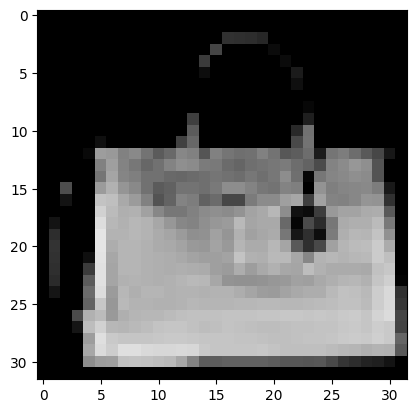


Worst Incorrect Prediction:
Confidence: 0.33600926399230957
Actual Index: 9 - Labels:  Ankle boot
Predicted Index: 1 - Labels:  Trouser


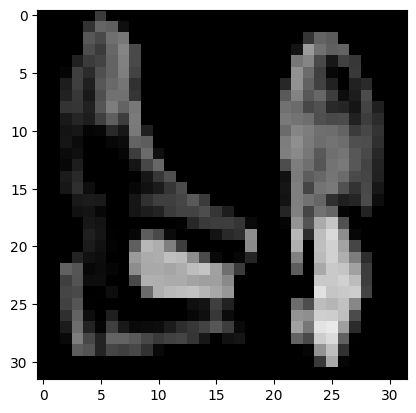

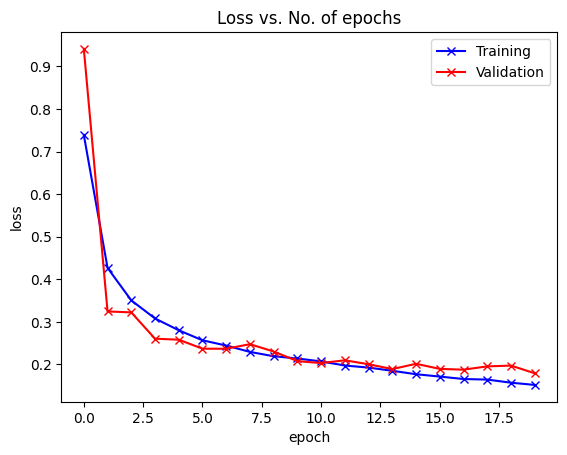

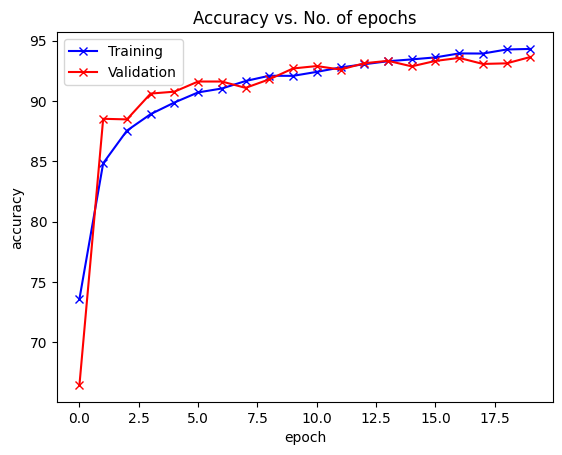

In [25]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet50_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet50_results['train_loss'], resnet50_results['val_loss'])
plot_acc(resnet50_results['train_accuracy'], resnet50_results['val_accuracy'])

## compare the accuracy on each class for each model

<ipython-input-26-71456af87f88>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


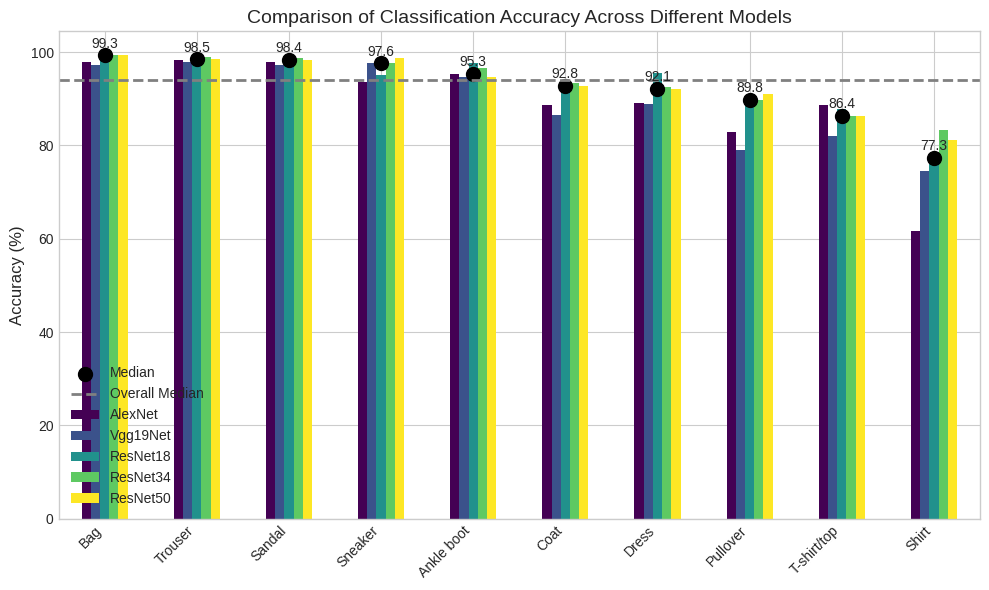

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compare_models(class_results_dict):
    # Create a DataFrame from the dictionary of class results
    df = pd.DataFrame(class_results_dict)

    # Calculate the median for all results
    df['Median'] = df.median(axis=1)

    # Sort the dataframe based on the median values
    df = df.sort_values(by='Median', ascending=False)

    # Select the best 5 and worst 5 classes
    best_5 = df.head(5)
    worst_5 = df.tail(5)

    # Combine best 5 and worst 5
    selected_classes = pd.concat([best_5, worst_5])

    # Plotting
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plot for models
    colors = plt.cm.viridis(np.linspace(0, 1, len(class_results_dict)))
    selected_classes.drop(columns='Median').plot(kind='bar', ax=ax, color=colors)

    # Scatter plot for median values
    x_values = np.arange(len(selected_classes))
    ax.scatter(x_values, selected_classes['Median'], color='black', s=100, label='Median')

    # Horizontal line for overall median
    overall_median = df['Median'].median()
    ax.axhline(overall_median, color='gray', linewidth=2, linestyle='--', label='Overall Median')

    # Annotating the median values on the chart
    for i, value in enumerate(selected_classes['Median']):
        ax.text(i, value+1, f'{value:.1f}', ha='center', va='bottom', fontsize=10)

    # Setting labels and title
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Comparison of Classification Accuracy Across Different Models', fontsize=14)
    ax.legend()

    # Setting x-ticks
    ax.set_xticks(np.arange(len(selected_classes)))
    ax.set_xticklabels(selected_classes.index, rotation=45, ha='right', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example class results
class_results_dict = {
    'AlexNet': alexnet_results['class_results'],
    'Vgg19Net': vggnet19_results['class_results'],
    'ResNet18': resnet18_results['class_results'],
    'ResNet34': resnet34_results['class_results'],
    'ResNet50': resnet50_results['class_results']
}

# Compare the models
compare_models(class_results_dict)

## compare the best image and worst confident on each class for each model

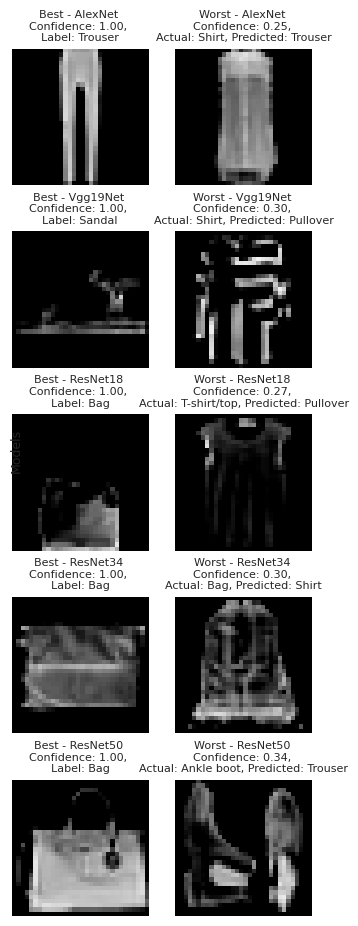

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_best_worst_predictions(model_histories, classes):
    sns.set_style("whitegrid")

    num_models = len(model_histories)
    fig_width = 3.3  # inches
    fig_height = 2 * num_models  # Adjust the height based on the number of models
    fig, axs = plt.subplots(num_models, 2, figsize=(fig_width, fig_height))

    for i, (model_name, results) in enumerate(model_histories.items()):
        # Best Prediction
        best_correct = results['best_correct'][0]
        image = best_correct['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Best - {model_name} \nConfidence: {best_correct['confidence'].item():.2f}, \nLabel: {classes[best_correct['label']]}", fontsize=8)
        axs[i, 0].axis('off')

        # Worst Prediction
        worst_incorrect = results['worst_incorrect'][0]
        image = worst_incorrect['image'].cpu().numpy().transpose(1, 2, 0)
        axs[i, 1].imshow(image)
        axs[i, 1].set_title(f"Worst - {model_name} \nConfidence: {worst_incorrect['confidence'].item():.2f}, \nActual: {classes[worst_incorrect['label']]}, Predicted: {classes[worst_incorrect['predicted_label']]}", fontsize=8)
        axs[i, 1].axis('off')

    # Adding labels and title
    fig.text(0.04, 0.5, 'Models', va='center', rotation='vertical', fontsize=9)
    # plt.suptitle('Best and Worst Predictions', fontsize=10, y=1.02)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, wspace=0.2, hspace=0.05)

    plt.show()

# Assuming model_results_1, model_results_2, and model_results_3 are dictionaries that hold the results from different models
model_histories = {
    'AlexNet': alexnet_results,
    'Vgg19Net': vggnet19_results,
    'ResNet18': resnet18_results,
    'ResNet34': resnet34_results,
    'ResNet50': resnet50_results
}
plot_best_worst_predictions(model_histories, classes)